In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import ast
import datetime as dt

import seaborn as sns
import cv2
import pandas as pd
import numpy as np

import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DP_DIR = 'data/shuffle-csvs/'
INPUT_DIR = 'data/'

BASE_SIZE = 256

NCSVS = 100
NCATS = 340

np.random.seed(seed=4371)
tf.set_random_seed(seed=4371)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [4]:
STEPS = 8500
EPOCHS = 200
size = 150
batchsize = 64

In [5]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(ast.literal_eval)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    
    df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [6]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 150, 150, 1) (34000, 340)
Validation array memory 2.85 GB


In [7]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

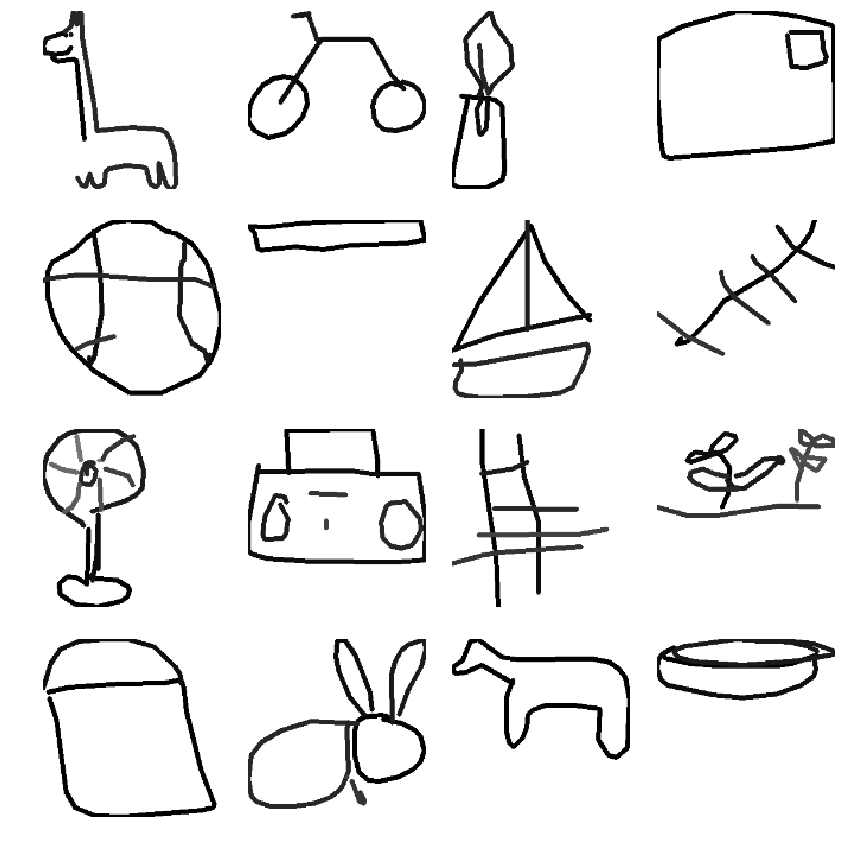

In [8]:
x, y = next(train_datagen)
n = 4
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

In [9]:
model = MobileNet(input_shape=(size,size,1), alpha=1.0, depth_multiplier=3, 
                  dropout=1e-3, include_top=True, weights=None, input_tensor=None, pooling='max', classes=NCATS)

model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy',
              metrics=[categorical_accuracy, top_3_accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 1)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 152, 152, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 75, 75, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 77, 77, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 96)        864       
__________

In [10]:
lr_reducer = ReduceLROnPlateau(monitor = 'val_categorical_accuracy' , factor = 0.5 , 
                               mode = 'max' , patience = 5 , verbose = 2 , min_delta = 0.005)

checkpointer = ModelCheckpoint('mobilenet_4371.h5', monitor='val_categorical_accuracy', 
                               verbose=2, save_best_only=True , save_weights_only = False , mode = 'max')

early_stopper = EarlyStopping(monitor = 'val_categorical_accuracy' , mode = 'max' , patience = 10)

model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = [checkpointer , lr_reducer, early_stopper]
)

Epoch 1/200
8500/8500 [==============================] - 3955s 465ms/step - loss: 2.3443 - categorical_accuracy: 0.4674 - top_3_accuracy: 0.6589 - val_loss: 1.7786 - val_categorical_accuracy: 0.5656 - val_top_3_accuracy: 0.7677

Epoch 00001: val_categorical_accuracy improved from -inf to 0.56556, saving model to mobilenet_4371.h5
Epoch 2/200
8500/8500 [==============================] - 4003s 471ms/step - loss: 1.5455 - categorical_accuracy: 0.6227 - top_3_accuracy: 0.8100 - val_loss: 1.4772 - val_categorical_accuracy: 0.6345 - val_top_3_accuracy: 0.8228

Epoch 00002: val_categorical_accuracy improved from 0.56556 to 0.63450, saving model to mobilenet_4371.h5
Epoch 3/200
8500/8500 [==============================] - 3999s 470ms/step - loss: 1.4124 - categorical_accuracy: 0.6532 - top_3_accuracy: 0.8322 - val_loss: 1.4150 - val_categorical_accuracy: 0.6508 - val_top_3_accuracy: 0.8337

Epoch 00003: val_categorical_accuracy improved from 0.63450 to 0.65079, saving model to mobilenet_4371.h

Epoch 26/200
8500/8500 [==============================] - 3971s 467ms/step - loss: 0.9612 - categorical_accuracy: 0.7582 - top_3_accuracy: 0.8997 - val_loss: 0.9335 - val_categorical_accuracy: 0.7644 - val_top_3_accuracy: 0.9025

Epoch 00026: val_categorical_accuracy did not improve from 0.76491
Epoch 27/200
8500/8500 [==============================] - 3972s 467ms/step - loss: 0.9490 - categorical_accuracy: 0.7611 - top_3_accuracy: 0.9011 - val_loss: 0.9349 - val_categorical_accuracy: 0.7632 - val_top_3_accuracy: 0.9035

Epoch 00027: val_categorical_accuracy did not improve from 0.76491
Epoch 28/200
8500/8500 [==============================] - 3972s 467ms/step - loss: 0.9509 - categorical_accuracy: 0.7606 - top_3_accuracy: 0.9008 - val_loss: 0.9324 - val_categorical_accuracy: 0.7663 - val_top_3_accuracy: 0.9038

Epoch 00028: val_categorical_accuracy improved from 0.76491 to 0.76629, saving model to mobilenet_4371.h5
Epoch 29/200
8500/8500 [==============================] - 3983s 469ms/


Epoch 00050: val_categorical_accuracy improved from 0.77774 to 0.77794, saving model to mobilenet_4371.h5
Epoch 51/200
8500/8500 [==============================] - 3979s 468ms/step - loss: 0.8872 - categorical_accuracy: 0.7763 - top_3_accuracy: 0.9090 - val_loss: 0.8791 - val_categorical_accuracy: 0.7781 - val_top_3_accuracy: 0.9101

Epoch 00051: val_categorical_accuracy improved from 0.77794 to 0.77806, saving model to mobilenet_4371.h5
Epoch 52/200
8500/8500 [==============================] - 3984s 469ms/step - loss: 0.8828 - categorical_accuracy: 0.7769 - top_3_accuracy: 0.9098 - val_loss: 0.8789 - val_categorical_accuracy: 0.7781 - val_top_3_accuracy: 0.9100

Epoch 00052: val_categorical_accuracy improved from 0.77806 to 0.77809, saving model to mobilenet_4371.h5
Epoch 53/200
8500/8500 [==============================] - 3985s 469ms/step - loss: 0.8835 - categorical_accuracy: 0.7765 - top_3_accuracy: 0.9099 - val_loss: 0.8789 - val_categorical_accuracy: 0.7782 - val_top_3_accuracy:

In [11]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))
del valid_predictions

34000/34000 [==============================] - 65s 2ms/step
Map3: 0.836


In [12]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape,x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))
del test

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 150, 150, 1)
Test array memory 9.40 GB


In [13]:
test_predictions = model.predict(x_test, batch_size=1, verbose=1)
print('Done!')
top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 962s 9ms/step
Done!


,a,b,c
0,234,281,289
1,144,36,150
2,305,62,110
3,187,303,304
4,113,56,165


(112199, 3)

,a,b,c
0,radio,stereo,submarine
1,hockey_puck,bottlecap,hot_tub
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,The_Eiffel_Tower
4,fireplace,campfire,leaf


(112199, 3)

In [14]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_{}.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape

,key_id,word
0,9000003627287624,radio stereo submarine
1,9000010688666847,hockey_puck bottlecap hot_tub
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent The_Eiffel_Tower
4,9000052667981386,fireplace campfire leaf


(112199, 2)